# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/bnekkalapudi/anaconda/envs/dlnd/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [3]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [4]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

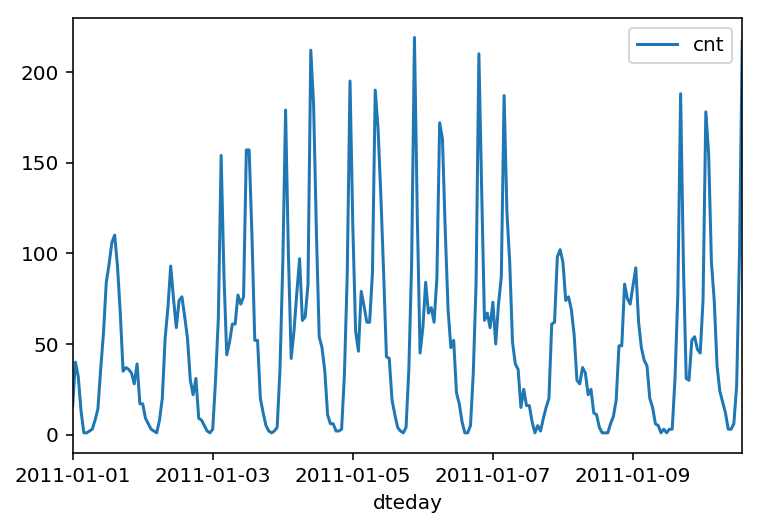

In [5]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [6]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [8]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [9]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [10]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        # self.activation_function = lambda x : 0  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation here
        self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        print(targets)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs
            
            #self.activation_function(final_inputs) # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
            # TODO: Calculate the hidden layer's contribution to the error
            # hidden_error = np.dot(output_error_term, self.weights_hidden_to_output)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            output_error_term = error * 1.0 #error * final_outputs * (targets - final_outputs)
            # hidden_error_term = None
            
            #hidden_error = error - hidden_outputs
            hidden_error = np.dot(self.weights_hidden_to_output, error)
            hidden_error_term = hidden_error * hidden_outputs * (1- hidden_outputs)
        
            #np.dot(output_error_term, self.weights_hidden_to_output) * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:, None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o #/ n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h #/ n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        # hidden_inputs = np.dot(self.input_nodes, self.weights_input_to_hidden) # signals into hidden layer
        hidden_inputs =  np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [11]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [12]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

[[ 0.4]]



----------------------------------------------------------------------
Ran 5 tests in 0.007s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [13]:
import sys

### Set the hyperparameters here ###
iterations = 300
learning_rate = 0.01
hidden_nodes = 9
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

3122    -0.829511
3076    -0.983877
409     -1.005929
6772     1.287502
5647     1.171728
2490     0.085656
8517    -0.322310
15309   -0.983877
1047    -0.360902
2061    -0.068710
13399    0.355796
14741    0.036038
14587   -0.840538
10898   -0.349876
2903    -0.052171
2690    -0.895668
7979    -0.818485
3141     0.228995
1342    -1.033495
1499    -0.537319
1563    -0.978364
10363   -0.311284
13040    0.256561
10830    0.471570
9233    -0.189997
9230     0.019499
11375   -1.027981
10414   -0.917720
11914    0.466057
8158     0.289639
           ...   
399     -0.851564
1275    -0.923233
11984    2.836671
1945    -0.575911
14602    0.306178
6565    -1.016955
526     -1.039008
10063   -0.835024
50      -1.027981
142     -1.016955
5917    -1.000416
3181    -0.327823
8867     1.552129
12691   -0.823998
4674     0.416439
12563    0.273100
79      -0.730276
6338     0.681066
9574    -0.333336
5562     0.449518
14646    0.587344
5713     0.388874
2541     1.066980
4306    -0.537319
5639    -0

Progress: 2.0% ... Training loss: 3.533 ... Validation loss: 5.00813392   -0.835024
179     -0.741303
7527    -0.449111
4113    -0.812972
2630     1.094545
4127     0.069117
9799    -0.994903
2255    -0.697198
13108    0.570805
1094     0.455031
11486   -0.278206
2023    -1.039008
12996    0.951206
6137    -0.801946
12481   -0.603476
1211    -0.564885
7633     0.537726
14865    2.456270
6377    -0.024605
3515    -0.079736
15308   -0.790920
403     -0.498728
7377    -0.972851
1624    -1.027981
1776     0.488109
12823    2.274339
11022   -0.063197
13063    0.455031
12421    3.266689
1817    -0.608989
           ...   
7522    -0.989390
6611    -0.686172
10487   -0.735789
3045     1.166215
14165    1.601746
881     -1.005929
4227    -0.868103
2382    -0.994903
9624    -0.686172
10414   -0.917720
14221    3.448620
7280    -0.553859
1406    -0.763355
9444    -0.333336
10909    3.057193
1105    -0.151406
3189     0.879536
11399   -1.011442
5834     1.100058
1600    -1.039008
13431    0.97325

/Users/bnekkalapudi/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


3197    -0.994903
12399    1.243398
9347     0.047064
6855    -0.928746
94      -1.033495
8857    -0.608989
12859   -0.669633
1068    -0.785407
14692    0.603883
1989     0.284126
5509    -0.322310
7386     0.162839
327     -1.000416
12203    1.717520
7551    -0.735789
10809    2.379087
11007    0.477083
6912    -0.162432
8912    -0.956312
9974     0.234508
3191    -0.085249
12310   -0.901181
8912    -0.956312
9759    -0.873616
15320    1.293015
10314   -0.377441
14958    0.295152
9925     0.013986
1946    -0.763355
5216    -0.388467
           ...   
14591   -1.016955
13201   -0.537319
4620     0.730683
9944     0.300665
13606   -1.000416
2349    -0.327823
3312    -0.377441
5076    -0.421545
6819     1.188267
11235    2.131000
11685   -1.011442
11848   -0.112814
285      0.069117
10920   -1.039008
15153    1.155189
11246    0.984284
2576    -0.774381
11275   -0.691685
9894     0.620422
7884    -1.016955
1688    -0.945286
13913    0.190404
6762     0.107708
13700   -0.939773
4353     0

Progress: 5.7% ... Training loss: 0.693 ... Validation loss: 1.2306019     0.135273
13150   -0.873616
7960    -0.697198
6441    -0.316797
4509     1.011849
14782   -0.983877
8698    -0.575911
9207     0.074630
12598   -1.016955
6642    -0.454624
8665    -0.586937
6970    -0.653094
13972    0.168352
1554    -1.027981
176     -0.636554
1857    -1.027981
8219    -1.027981
10618    1.315067
4978    -0.261667
2369    -0.597963
9433    -0.708224
13458   -0.686172
8218    -1.033495
6172     1.932530
8983    -1.011442
770     -0.592450
12575   -0.989390
13933    3.707734
3499     0.631448
10572    0.295152
           ...   
10264    2.208182
14960    0.807866
4785    -0.796433
740     -0.829511
8828     0.686579
13384    0.763762
3348    -0.449111
1101    -0.096275
4384    -0.145892
5545    -0.603476
7523    -0.961825
8848    -0.476676
12363    2.621662
1804    -0.774381
11986    2.660253
2394     0.069117
2938    -0.410519
831     -1.027981
14967    1.254424
6684    -1.016955
12203    1.71752

Progress: 8.0% ... Training loss: 0.620 ... Validation loss: 1.0645788     1.094545
5290    -0.393980
2150    -0.360902
4586    -0.603476
2125     0.140786
3334     0.664527
9441     0.201430
12030   -0.460137
10034   -1.011442
2263    -1.027981
14965    3.917230
4827    -0.978364
3801    -0.857077
12349    1.689955
9609     1.425328
15187   -0.234101
644     -1.000416
4834     1.089032
5729    -1.005929
7543    -0.338849
155     -0.366415
4504    -0.305771
560     -0.531806
14459    1.612772
9940    -0.901181
12919    0.730683
4363     1.960095
7093    -0.989390
10278    1.717520
15189   -0.537319
           ...   
2785    -0.355389
8063    -0.879129
11318   -0.746816
324     -0.890155
14535   -0.471163
15378   -0.603476
12579    2.886288
9462    -1.011442
1263    -0.548346
14642    1.634825
8122    -0.713737
9524     0.559779
7382    -0.890155
13181    0.714144
1022    -0.465650
1601    -1.033495
1776     0.488109
12001   -0.906694
3359    -0.002553
14379    2.809106
3466    -0.51526

Progress: 10.3% ... Training loss: 0.580 ... Validation loss: 0.94212777   -0.074223
5881    -0.983877
2691    -0.950799
1055     0.361309
12122    0.934666
8944    -0.195510
6939     1.144163
2648    -0.680659
15434    1.750599
8228    -0.250641
1114    -1.027981
8707    -0.620015
3755     0.129760
7786    -0.884642
5565     1.381224
1695    -0.432571
2026    -0.294745
8963    -0.537319
9908     0.273100
3590     0.383361
15039    0.344770
9448    -0.107301
6274    -0.531806
9833     0.124247
981     -0.195510
425     -0.156919
13679   -0.972851
7296     0.846458
6363     1.877399
41      -0.752329
           ...   
6112    -0.923233
4855    -0.895668
1571    -0.857077
3480    -0.101788
284     -0.647581
8865    -0.608989
12518    1.022875
3437    -0.961825
1133    -0.884642
1866    -0.449111
15182    1.546616
11881   -0.912207
4958     0.835431
15319    1.535590
11501    1.050441
11289    1.127623
12085    0.758249
6280    -0.945286
9321    -0.978364
8469    -0.377441
8605     0.0856

Progress: 12.7% ... Training loss: 0.537 ... Validation loss: 0.8843103    -0.967338
9371     0.394387
829     -0.961825
8904    -0.884642
12278    2.213696
8772     1.419815
4641    -0.768868
7908    -1.039008
2723    -0.035631
12544    0.333743
14010   -0.145892
8201     0.240021
9363    -1.000416
13035    2.086895
499     -0.829511
9864    -0.978364
7087    -0.432571
6769     0.223482
6214     0.019499
5972     0.206943
7363    -0.333336
6328    -0.421545
6676     1.563155
8632     0.151813
10226   -1.027981
5064    -0.620015
11286    0.355796
1565    -0.928746
12301   -0.438084
13593    0.317204
           ...   
11631    0.681066
14005    0.609396
2116    -0.857077
11159   -0.978364
12791   -0.989390
11221    3.228098
201     -0.537319
13709   -0.002553
4791     0.306178
2173    -0.890155
9831     0.262074
12969    0.240021
13123   -0.482189
5322     0.565292
2650     0.901588
10739    0.173865
5462     1.210319
9571    -0.123840
14121    0.322717
2215    -1.039008
5978     1.1827

Progress: 15.0% ... Training loss: 0.496 ... Validation loss: 0.8215963    -0.449111
3630    -0.978364
13417   -0.151406
15378   -0.603476
2090    -0.752329
13917   -1.011442
4285     0.923640
10416   -1.005929
13376    0.273100
14682   -0.311284
3925    -0.046657
13791    1.309554
6543    -0.868103
10153   -0.901181
14326   -0.835024
9410    -0.873616
5305    -0.382954
3856    -0.167945
15202    2.533453
6211     0.102195
6880    -0.669633
14087   -1.022468
2420     0.405413
2005    -0.719250
9176    -0.812972
12963    2.395626
4295     0.234508
10386    0.300665
10344   -1.033495
2745     0.278613
           ...   
5841    -0.592450
4190     0.069117
10242    0.388874
1908    -0.471163
5723    -0.178971
14766    0.234508
2874     0.030525
9801    -0.482189
8787    -0.487702
972     -0.978364
1052    -0.592450
3847    -0.901181
7283    -0.873616
7249     0.427465
7575    -0.631041
8995     0.085656
4787    -0.316797
3533    -1.011442
14257   -0.013579
15295    0.543240
9078    -1.0390

Name: cnt, Length: 128, dtype: float64
Progress: 17.3% ... Training loss: 0.455 ... Validation loss: 0.75813800   -0.840538
14167    2.561018
8375    -0.195510
4405    -0.261667
6855    -0.928746
11301   -0.597963
1510    -0.338849
6721    -0.796433
6074     0.179378
1889    -0.526293
12647   -1.000416
10134   -0.779894
10222   -0.961825
1239    -0.289232
5652    -0.691685
10629   -0.184484
411     -1.033495
12194   -0.675146
4624     1.342633
8694    -1.027981
9009    -0.972851
10377    0.300665
4107    -0.520780
1763    -1.027981
15390    0.653501
6904     0.708631
13383    1.458407
2175    -0.835024
6935     0.047064
8950     0.091169
           ...   
3743    -0.101788
2923     2.004199
7150     0.857484
11637   -0.631041
3924    -0.107301
10092    0.118734
10078   -0.983877
478     -0.895668
887     -0.818485
8213    -0.278206
13903    0.515674
4142     1.397763
4849    -0.564885
4566    -1.011442
12312   -0.978364
10503    1.485972
5759    -0.272693
14257   -0.013579
6817     1.2

Progress: 19.7% ... Training loss: 0.423 ... Validation loss: 0.6748952    -0.482189
14572    0.736196
3827     0.190404
3180    -0.471163
1301    -0.476676
7521    -0.923233
823     -0.614502
14814    0.499135
3608    -0.890155
11958    0.796840
10703   -1.005929
9835    -0.123840
8988    -0.548346
8909    -1.033495
8967     0.162839
12787   -0.531806
9645    -0.697198
11084   -0.994903
5440     0.168352
3322     1.210319
2675     0.052578
2859    -1.005929
14756   -0.928746
10811    1.993173
10297   -0.956312
3493     0.725170
4041     0.670040
8803     1.430842
3339    -0.961825
13149   -0.724763
           ...   
7265     1.133137
10473    2.544479
2473    -0.735789
14720    0.736196
1275    -0.923233
8930    -0.675146
11871   -0.002553
14322   -0.063197
11255   -1.022468
11153    0.124247
4190     0.069117
1075    -0.366415
7741    -1.033495
3551     0.002960
11056    0.510161
12455   -0.989390
12157    1.243398
2818     1.000823
15401   -0.454624
5062    -0.564885
10936    0.6755

Progress: 22.0% ... Training loss: 0.409 ... Validation loss: 0.67813330    2.042791
13352    1.601746
6578     0.736196
6102     0.195917
72      -1.033495
8644    -0.873616
9987    -1.011442
12715   -0.851564
9278    -0.052171
6647     1.259937
1154    -0.735789
10705   -1.027981
4609    -0.123840
5112    -0.008066
11620    0.576318
6793     1.033902
9226     1.783677
2855     0.195917
2254    -0.752329
4255    -0.879129
5304    -0.195510
14122    0.388874
14097    0.361309
9736    -0.101788
4966     0.091169
10467   -0.879129
2653    -0.234101
477     -0.857077
555      0.267587
68      -0.978364
           ...   
1472    -0.983877
1673     0.510161
6754    -0.829511
14786    2.103434
10537   -1.011442
1378     0.432978
7611     0.763762
5247     0.151813
2118    -0.983877
8423     0.135273
15124    0.802353
8839    -1.027981
5405    -1.011442
2696    -0.581424
7504     0.730683
14540   -0.741303
6178    -0.906694
15351    0.317204
15119   -1.000416
667     -1.033495
14493   -0.6641

Progress: 24.3% ... Training loss: 0.350 ... Validation loss: 0.59210344   -1.033495
7885    -0.923233
7715    -1.011442
3461    -0.901181
2010    -0.564885
13733    0.206943
4835    -0.300258
1593    -0.752329
9090     0.019499
1549    -0.928746
9305     1.215832
12395    1.563155
11586   -0.504241
11928   -0.851564
7192     0.355796
12664    0.554266
5222     0.278613
7800     0.686579
12684    2.224722
3382     0.829918
12277    3.283228
3524     1.254424
10986   -0.041144
9777     1.822269
4473    -0.686172
15421    3.277715
9899     0.096682
635     -0.669633
13922    1.612772
48      -1.033495
           ...   
15366    0.807866
5081    -0.134866
5125     0.879536
15052    0.763762
5755    -0.625528
1267    -0.829511
386     -0.570398
5384    -0.465650
11065   -0.460137
4704    -0.184484
701     -0.746816
4927    -0.895668
12644   -0.520780
14610   -0.217562
8994     0.091169
6166    -0.002553
8933    -0.967338
13091    1.100058
3509    -1.022468
14838    2.412166
7609     0.1077

Progress: 26.7% ... Training loss: 0.334 ... Validation loss: 0.5473379     2.268826
12598   -1.016955
4231    -0.906694
5177    -0.349876
4434    -0.316797
14601    0.118734
3607    -1.000416
1536    -0.267180
10547    0.322717
9945    -0.267180
6710    -1.005929
12831    1.083519
11423   -1.027981
6444    -0.675146
7254    -0.250641
4544    -0.377441
12494    0.940180
10089   -0.118327
1375    -0.515267
14941    3.873125
11957    0.361309
5828    -0.818485
2885    -1.022468
13401    0.135273
13096    2.175104
2829     0.686579
1129    -0.719250
2008    -0.471163
11203   -0.807459
11771    1.276476
           ...   
563     -0.405006
14046    0.306178
12704    0.195917
4987     0.719657
8078    -0.653094
1111    -0.873616
214     -1.027981
4199     0.030525
11937    0.444005
13195   -0.829511
14945    0.217969
7931    -1.039008
14304   -0.835024
13685    1.055954
12308   -0.625528
7170     0.118734
6276    -0.669633
14913   -0.256154
3975     0.956719
1114    -1.027981
1346    -0.3609

Progress: 29.0% ... Training loss: 0.314 ... Validation loss: 0.5305102     0.146299
3373    -0.272693
4017     0.659014
1359    -0.785407
229     -0.636554
11426    0.195917
7236    -1.016955
14734   -1.000416
8875     0.278613
3954     1.535590
2412    -0.371928
14982    0.725170
5482    -0.537319
6212    -0.311284
1929    -1.011442
9818    -0.647581
1799     0.190404
249     -0.520780
9054    -1.039008
4477     0.537726
11984    2.836671
8588    -0.068710
12503   -0.989390
12849    1.993173
13630   -0.978364
4948    -0.812972
12696   -0.917720
3735    -0.294745
2499    -1.005929
8088     0.102195
           ...   
14805   -0.879129
8357    -0.344363
9809     1.182754
2342    -0.537319
4401     0.565292
4690     1.226858
9766    -0.245127
8668    -0.884642
11498   -0.895668
2995     2.252287
11558    1.640338
2898     0.438491
14278   -0.994903
2360    -0.857077
14493   -0.664120
9312    -0.476676
2530     1.138650
5037     1.458407
4446    -1.011442
2811    -0.416032
11677    1.5080

Progress: 31.3% ... Training loss: 0.304 ... Validation loss: 0.5187505     1.447381
12497    0.135273
12550   -0.978364
9929     1.833295
14611   -0.686172
12019   -0.823998
9682     0.085656
10637   -0.195510
12796    0.791327
9937    -1.016955
13876    0.477083
5920    -0.967338
6531     2.180617
5473    -0.178971
2743    -0.906694
9241    -0.680659
12531    2.544479
9353    -0.283719
10877    1.204806
15186    0.036038
5947    -0.388467
8148    -1.016955
13387   -0.752329
1643    -0.983877
9110    -0.360902
8913    -0.553859
10735   -0.090762
5424    -0.300258
13684    0.201430
11608    0.603883
           ...   
11291    2.153052
7757    -0.873616
10394   -0.895668
345     -0.730276
11824    0.223482
3981     0.670040
12530    1.728547
10158   -0.680659
6331     0.085656
239      0.151813
8710     0.190404
12071   -1.027981
54      -0.559372
1097    -0.421545
7828    -0.278206
8404    -0.123840
5332    -1.027981
7394     1.629312
11686   -1.016955
14002    2.053817
2705    -0.2837

Progress: 33.7% ... Training loss: 0.309 ... Validation loss: 0.5257632     1.061467
15414    0.019499
6394    -0.823998
9307     0.554266
9255    -0.090762
2066    -0.895668
10861    2.974497
7658     0.074630
12279    1.596233
12415    0.692092
727     -0.476676
15194   -0.730276
10762    0.460544
11156   -0.460137
6369    -0.531806
7694    -0.945286
2317    -0.471163
10757    2.561018
13584   -0.719250
5266     1.304041
3768    -0.024605
12513    1.712007
14785    0.030525
5141    -0.868103
13226    1.822269
10593    0.455031
1937     0.206943
1809    -1.011442
10245   -0.702711
10374    0.840945
           ...   
4798    -0.245127
3615     1.469433
5969    -0.934260
93      -1.011442
1167    -0.597963
8506    -1.033495
5318     0.504648
13201   -0.537319
14261    0.195917
8806     0.592857
8667    -0.680659
2639    -0.708224
11932    0.862997
8389    -0.890155
751     -0.079736
10317   -0.586937
4250    -0.669633
2082    -0.432571
9682     0.085656
7725    -0.162432
4654     0.3999

Progress: 36.0% ... Training loss: 0.525 ... Validation loss: 0.54011503    2.175104
4883     0.146299
4017     0.659014
4469    -0.906694
3728    -0.393980
6654     0.019499
856     -1.039008
15378   -0.603476
9072    -0.614502
5236    -0.983877
18      -0.851564
12261   -0.967338
5487     0.664527
163     -0.956312
5618    -0.245127
14135   -0.994903
5815     0.918127
3334     0.664527
11694    0.129760
1722    -0.614502
2218    -0.162432
9585     1.623799
3250     1.805729
6614    -0.989390
15068   -0.972851
12032   -0.030118
10328    0.603883
9493    -0.041144
4876    -1.011442
3882     0.675553
           ...   
10531   -0.228588
237     -0.895668
11445   -0.923233
5220    -0.421545
7295     1.083519
11203   -0.807459
5548    -1.011442
426     -0.427058
10809    2.379087
4786    -0.443598
3698    -0.818485
7448    -0.642068
8627    -1.011442
15380   -0.840538
9625    -0.752329
11205   -1.022468
6942    -0.256154
13224   -0.812972
3038     0.201430
8852    -0.774381
3994     0.1738

Progress: 38.3% ... Training loss: 0.285 ... Validation loss: 0.47710563   -0.223075
4159    -0.923233
7522    -0.989390
12206    1.133137
5998    -0.030118
2375    -0.399493
10421    2.390113
12252    3.580933
10073   -0.482189
3745    -0.509754
14362    1.111084
14505    1.789190
2671    -0.956312
4889    -0.272693
7031     0.058091
8746    -0.614502
13875    2.290878
4413     0.967745
12759    1.199293
5360    -0.388467
1937     0.206943
5231     0.107708
3455     0.063604
11475   -0.173458
12148    0.548753
14871    0.741710
903     -1.039008
6551     0.162839
12495    0.956719
10686    0.510161
           ...   
2488    -0.250641
14017   -0.956312
14450    1.888425
6803    -0.620015
8635     0.609396
9819    -0.779894
13189    0.350283
9194    -0.906694
12201    1.519050
3331     1.320580
11794    1.375711
5904    -0.349876
12485    1.524563
15111    1.348146
8159     0.421952
5013     1.232372
11933    0.085656
7223    -0.096275
1289    -0.669633
9393     0.102195
4395    -0.9563

Progress: 40.7% ... Training loss: 0.289 ... Validation loss: 0.4746062    -1.005929
14171    2.489348
15035    2.765001
7198    -0.123840
4206    -1.016955
14705   -0.002553
1411    -1.033495
2254    -0.752329
13853    0.962232
10492   -0.812972
9868    -0.961825
486     -0.895668
6349    -0.989390
13363   -0.807459
8530    -1.027981
10103   -0.934260
6812     0.868510
3000    -0.405006
12848    2.180617
13914   -0.283719
6740    -0.664120
2767    -1.005929
6043     0.069117
401     -0.355389
288     -0.840538
164     -1.005929
1568    -0.735789
4261     0.135273
6801    -0.300258
10342   -0.989390
           ...   
7325    -0.405006
2248    -0.812972
14809   -0.206536
1813    -0.945286
5744     1.397763
13723   -0.835024
11293    2.638201
8042     0.631448
1118    -0.796433
10375   -0.256154
10733    2.583070
1345     0.135273
1485    -0.857077
1176    -0.774381
9417     0.085656
3725    -1.033495
8838    -1.016955
12513    1.712007
4520    -0.410519
9297    -0.873616
4028     1.9104

Progress: 43.0% ... Training loss: 0.276 ... Validation loss: 0.4534164    -0.217562
5776    -0.851564
3392    -0.504241
6571     0.102195
4852    -1.005929
10049    1.430842
268     -0.774381
1801    -0.184484
1432    -0.790920
7141    -0.983877
14806   -0.967338
15056    0.763762
13816    0.488109
3767     0.157326
3206    -0.746816
11823    0.537726
6476     0.322717
10622    4.231474
14003    1.882912
4496    -0.377441
199     -0.647581
387     -0.531806
1823     0.455031
13022    1.061467
6367     0.036038
1568    -0.735789
9567    -0.449111
2621    -0.912207
4068    -0.344363
15282    0.168352
           ...   
1535     0.328230
3474     0.945693
2665    -0.702711
8691    -0.857077
13916   -0.917720
398     -0.890155
2791    -0.989390
238     -0.498728
5102     0.146299
8339    -1.027981
5935     0.113221
3203     0.069117
4888    -0.344363
852     -0.906694
14620   -0.366415
8510    -0.945286
6112    -0.923233
12237   -1.016955
4865    -0.145892
614     -0.702711
10143    1.0780

Progress: 45.3% ... Training loss: 0.278 ... Validation loss: 0.4488760    -0.068710
8177     0.168352
14410    0.703118
121     -0.520780
506     -1.027981
5600    -0.465650
9155    -0.697198
12750   -0.008066
7259    -0.989390
13650   -0.002553
14114    1.513537
2559    -0.068710
9078    -1.039008
13121    0.195917
12916    0.510161
4646     1.270963
1135    -0.956312
4731    -0.928746
13438   -1.016955
14505    1.789190
9077    -1.022468
15253    2.742949
8207    -0.212049
11861   -0.719250
4397    -1.022468
11211    2.665766
594     -0.956312
9898    -0.101788
6730    -0.961825
4856    -0.438084
           ...   
8840    -1.022468
11602    0.515674
8344     1.144163
15422    1.789190
2949     0.427465
1660     0.251048
6237    -0.134866
12800    0.609396
7404    -0.983877
2720    -0.570398
11668    0.008473
6614    -0.989390
2271     0.069117
9110    -0.360902
487     -0.823998
2693    -1.005929
15232    0.157326
6634    -0.333336
7139    -0.768868
4355     0.206943
9706     0.3999

Progress: 47.7% ... Training loss: 0.277 ... Validation loss: 0.46411776    0.223482
1446     0.002960
1270    -0.978364
687     -0.950799
14163   -0.002553
9171    -1.022468
1562    -0.978364
5641     0.642475
8280     0.190404
14774    2.456270
2949     0.427465
14169    2.252287
4881     0.868510
13221   -0.956312
2897    -0.234101
141     -1.039008
3879    -0.002553
4506     0.273100
2205     0.747223
10255    0.614909
14139    2.638201
7815    -0.994903
1103     0.758249
10046   -0.129353
12235   -0.846051
1668    -1.027981
5635    -0.956312
3093     0.444005
11391    0.526700
5501    -1.016955
           ...   
11022   -0.063197
7818    -0.432571
11026    0.157326
3969    -0.653094
5115    -0.675146
6021    -0.201023
7983    -0.901181
6866     0.631448
1291    -0.857077
13676   -0.173458
12173    1.293015
10370   -0.912207
3730     1.337120
961     -0.245127
6543    -0.868103
4513    -0.741303
2043    -1.027981
15168   -0.961825
11521   -0.366415
3456    -0.156919
620     -0.9618

Name: cnt, Length: 128, dtype: float64
Progress: 50.0% ... Training loss: 0.303 ... Validation loss: 0.4858821    -0.355389
5847    -1.039008
12008    2.301904
13812    3.040654
2518    -0.118327
5947    -0.388467
14004    1.778164
14676   -0.101788
11032    0.477083
13184    0.813379
4944    -0.085249
12297    0.355796
11168    2.709871
12218    1.436355
742     -0.008066
4872    -0.173458
12600   -0.823998
5745     0.499135
3140     0.262074
13007   -1.022468
12705    0.162839
13001   -0.096275
6014    -1.000416
12356   -0.967338
14899   -0.972851
3482    -0.476676
9469     0.444005
11073   -0.300258
14316    3.432081
9046    -0.052171
           ...   
2205     0.747223
10405    0.918127
8100    -1.033495
6305    -0.835024
5155     0.025012
9752     0.543240
12821    1.678929
13947    2.803592
11535    0.659014
10317   -0.586937
3246    -1.016955
14792    0.515674
8479    -0.950799
14744    0.763762
4993    -0.658607
7484     0.581831
8330    -0.283719
5476    -0.691685
8460    -1.0

Progress: 52.3% ... Training loss: 0.273 ... Validation loss: 0.44715421    3.277715
2183    -0.542833
11884    0.912614
880     -1.033495
948     -0.989390
10928    0.477083
12921    0.444005
12485    1.524563
14656    0.614909
3618     1.381224
4469    -0.906694
11509    1.640338
1345     0.135273
6537    -0.680659
6810    -0.498728
2701    -0.184484
8624    -0.945286
9715     1.193780
9112    -0.410519
180     -0.879129
7175    -0.267180
14176    0.818892
6819     1.188267
4257     0.295152
10060   -0.471163
2170    -0.305771
5905    -0.382954
7640    -0.531806
3332     1.452894
2239    -1.039008
           ...   
7864     1.430842
10072    0.013986
10402    0.355796
9008    -1.011442
1136    -0.950799
12694   -1.022468
2268    -0.504241
13992   -0.983877
2401    -0.785407
11520   -0.934260
15303    1.386737
9619     0.934666
2725    -0.581424
11543   -1.000416
3571     2.108947
13391   -1.005929
14550    1.485972
3437    -0.961825
12452   -0.884642
13193   -0.371928
9409    -0.5097

Progress: 54.7% ... Training loss: 0.281 ... Validation loss: 0.4697147    -0.063197
6604     1.519050
13103   -1.005929
10230    2.075869
798     -0.614502
9261     0.681066
8226    -0.261667
13174   -0.851564
9952     0.366822
8098    -0.978364
9267    -0.884642
9729     1.794703
11119    0.730683
6963     0.802353
1451    -0.206536
12792   -0.835024
12680    2.340496
13343   -0.939773
5184    -0.234101
15282    0.168352
14198    0.835431
6548    -0.311284
8285    -0.482189
15295    0.543240
1103     0.758249
14844    2.974497
13441   -0.206536
11301   -0.597963
2559    -0.068710
8529    -1.027981
           ...   
7295     1.083519
10502    1.938043
1251    -0.851564
4631     0.344770
3418     1.259937
2947     0.907101
11375   -1.027981
14737    0.118734
9615    -0.239614
11675    1.954582
9619     0.934666
2019    -0.983877
1062    -0.950799
5927    -0.631041
10685    2.577557
12081    0.322717
15325    3.150915
84      -0.586937
4495    -0.901181
2089    -0.636554
2390    -0.2451

Name: cnt, Length: 128, dtype: float64
Progress: 57.0% ... Training loss: 0.265 ... Validation loss: 0.44212296    0.697605
4518    -1.011442
12556    0.526700
15177    3.090271
15402   -0.664120
14335    2.175104
1736    -0.884642
8211     0.427465
9525     0.063604
4338     1.447381
10200   -1.022468
12739   -0.752329
2698     1.403276
14233   -0.112814
11967    0.813379
13519    1.734060
12649   -0.785407
7511    -0.024605
7279    -0.410519
6586    -0.675146
9914    -1.011442
12563    0.273100
669     -1.000416
7670    -0.934260
3144    -0.399493
13069    2.412166
12262   -1.000416
11711   -1.016955
7646    -1.022468
9325     0.361309
           ...   
13115    1.342633
6929     1.171728
11151    0.725170
9005    -0.950799
397     -0.923233
6741    -0.581424
9527    -0.564885
8114     0.708631
7944     0.477083
7710    -0.548346
1357    -0.559372
14070    0.036038
3101    -0.851564
12634    1.033902
1115    -1.027981
10023    0.532213
3362    -0.851564
4497     0.703118
2163    -0.9

Progress: 59.3% ... Training loss: 0.362 ... Validation loss: 0.4732927    -0.206536
12937    0.019499
11191    0.449518
11786    0.890562
7988     0.769275
10432    1.298528
68      -0.978364
7310    -1.016955
6011    -0.989390
14309    0.399900
11531    0.868510
1580     0.383361
15060    3.906204
570     -0.823998
10150   -0.647581
7619    -0.790920
7218     0.212456
2009    -0.570398
9534    -0.961825
4775     0.002960
12784    0.670040
13933    3.707734
13681   -0.945286
14950   -1.011442
6731    -0.978364
8045    -0.416032
13910    2.318444
10920   -1.039008
14430    0.350283
8414    -0.691685
           ...   
9552    -0.763355
3418     1.259937
6504    -0.382954
4880    -0.366415
12892    0.763762
4815     0.344770
4487     0.206943
604     -0.774381
2339    -0.746816
12911   -0.983877
12160    0.339256
4686    -1.016955
3732    -0.526293
13140    2.131000
6629     0.322717
6073    -0.300258
9908     0.273100
4066     1.337120
6224    -0.344363
1202    -1.033495
5882    -0.9066

Progress: 61.7% ... Training loss: 0.264 ... Validation loss: 0.4403650    -0.884642
4338     1.447381
11943    1.414302
5319     1.033902
11632    0.251048
955     -0.581424
1170    -0.476676
6853    -1.039008
6840    -0.129353
7011     1.634825
2248    -0.812972
14197    1.033902
5370     0.625935
14218    0.659014
15373   -0.460137
249     -0.520780
1905    -1.016955
7217     1.557642
9399    -0.019092
9548     0.818892
12094   -1.022468
12278    2.213696
14864    2.781540
2289    -1.022468
9536     0.603883
9658    -0.697198
677     -0.746816
7296     0.846458
6590    -1.016955
1190    -0.664120
           ...   
6902    -0.901181
353     -1.033495
11792    0.956719
6355     0.019499
5994     1.204806
2675     0.052578
5385     0.653501
9542    -0.030118
4367     0.306178
14589   -0.994903
8622    -0.851564
1350    -0.614502
3698    -0.818485
13436   -0.906694
13494    0.636961
10768    1.535590
3790     0.471570
2710     0.157326
5554     1.535590
14664   -0.961825
2580    -0.2947

Progress: 64.0% ... Training loss: 0.281 ... Validation loss: 0.46813651    0.008473
554     -0.449111
14359    2.406652
11829   -0.592450
8252    -0.178971
7379    -1.016955
9107     0.405413
4704    -0.184484
13654   -0.807459
145      0.113221
872     -0.487702
15025   -0.956312
989     -0.763355
8350    -0.289232
3398     0.025012
2520    -0.427058
15434    1.750599
8171    -1.033495
11629    2.489348
5032    -0.167945
6614    -0.989390
4164    -0.217562
3405     1.039415
8543    -0.410519
3609    -0.564885
5411     0.212456
7372     0.488109
11701    2.704357
10544    0.223482
8970     0.201430
           ...   
11107   -0.741303
12012    1.982147
12228    3.261176
13665    1.678929
12068   -0.868103
7772     0.201430
13390   -1.027981
11931    2.450757
6497     0.328230
11822    1.375711
5429    -1.027981
3610    -0.355389
7326    -0.559372
1697    -0.195510
1847     0.647988
4837    -0.454624
9786     1.519050
7187    -1.022468
6488    -0.691685
3686    -0.035631
1798     0.6535

Progress: 66.3% ... Training loss: 0.260 ... Validation loss: 0.4395280     0.228995
12478   -0.823998
9140    -0.438084
9709    -0.096275
1176    -0.774381
2203    -0.112814
6699     2.285365
7243    -0.438084
8169    -0.994903
8972    -0.250641
12758    1.927017
7820     0.278613
13485   -0.713737
7021    -1.016955
6301    -0.719250
9405     0.802353
2232    -0.449111
8649    -1.000416
11537   -0.305771
10423   -0.140379
396     -1.027981
4220     2.197156
3223    -0.901181
5967    -0.994903
8645    -0.779894
2515     1.221345
190     -1.039008
12892    0.763762
9628    -0.994903
12499   -0.173458
           ...   
4217    -0.002553
3656    -0.427058
3556    -1.011442
12825    2.312931
11747    0.923640
2879    -0.217562
3011     0.085656
4251    -0.873616
10686    0.510161
11579    0.978771
1085    -0.801946
5839    -0.366415
4324    -0.697198
1255    -0.719250
8470    -0.575911
1603    -0.917720
2000    -1.000416
4522     1.254424
5576    -0.482189
13648    0.388874
5528    -0.4160

Progress: 68.7% ... Training loss: 0.256 ... Validation loss: 0.4319756    -0.653094
4897    -0.443598
6415     0.195917
5984    -0.167945
816     -0.399493
11240   -0.691685
983     -0.151406
8392     1.188267
9043     1.502511
12973    1.513537
11889   -0.030118
13753   -0.024605
10741    0.173865
6904     0.708631
14659   -0.217562
6834     1.237885
7856    -0.923233
10      -0.846051
8903    -0.730276
7614    -0.432571
12841   -0.906694
13592    0.675553
3226     1.640338
7043    -1.027981
14534    0.565292
10903    0.129760
10855    0.107708
9427     1.436355
10128   -0.835024
8188    -0.134866
           ...   
4367     0.306178
4967     0.085656
2322     0.251048
985     -0.355389
7066    -0.983877
2629     0.703118
7651     0.217969
10148   -0.305771
2410     0.609396
10189   -0.327823
1842    -0.377441
7739    -0.923233
11104   -0.013579
8147    -0.939773
13914   -0.283719
2936    -0.972851
2000    -1.000416
8218    -1.033495
5259    -0.917720
2568    -0.289232
11050    0.1904

Progress: 71.0% ... Training loss: 0.265 ... Validation loss: 0.4449795    -0.796433
14125    3.542342
15      -0.438084
11186    1.089032
676     -0.669633
3634    -0.504241
12212   -0.967338
8054    -0.945286
10122   -0.493215
555      0.267587
14523   -0.333336
1298    -0.967338
886     -0.719250
7380    -1.022468
14668    0.874023
13040    0.256561
192     -1.011442
9254    -0.134866
5032    -0.167945
5223     0.008473
5901    -0.686172
13651    0.008473
2939     0.157326
852     -0.906694
7296     0.846458
354     -1.039008
9548     0.818892
3606    -0.961825
5902    -0.504241
6627     1.122110
           ...   
12259   -0.708224
1279    -0.349876
3828    -0.393980
10369   -1.039008
9401     0.025012
3466    -0.515267
14120    0.609396
11155   -0.360902
13140    2.131000
12038    1.425328
2493     0.532213
10010   -1.033495
4026     0.802353
10961    0.002960
4798    -0.245127
7850     1.248911
7528     0.714144
14944    0.879536
7492    -0.178971
1695    -0.432571
2065    -0.7633

Progress: 73.3% ... Training loss: 0.260 ... Validation loss: 0.4259827     0.008473
11764    0.945693
4578     0.466057
6098     0.929153
3296    -0.945286
13044    3.073732
9801    -0.482189
4082    -0.697198
1309    -0.344363
5178     0.510161
5331    -0.989390
13290    0.118734
8201     0.240021
1868    -0.575911
9362    -0.961825
7364    -0.234101
12724    0.763762
6893    -0.245127
12857   -0.063197
4542    -1.016955
9642    -0.250641
9580    -1.022468
8632     0.151813
4181    -1.033495
420     -0.614502
5368    -0.041144
2798     0.504648
5096    -0.487702
3193    -0.735789
171     -0.708224
           ...   
355     -1.027981
5686     0.157326
13009   -0.895668
9654    -1.027981
10543   -0.145892
1349    -0.570398
5482    -0.537319
2479    -0.956312
9512     0.245534
9114    -0.085249
5735    -0.283719
9973     0.146299
5469     0.559779
9010    -0.862590
15322    1.546616
10481    0.449518
4258     1.667903
12377   -0.118327
8691    -0.857077
13266   -0.206536
13728   -0.7964

Progress: 75.7% ... Training loss: 0.261 ... Validation loss: 0.44013473    0.217969
8110    -0.013579
13999    1.965608
6143     1.028388
6287     1.491485
382     -0.730276
10222   -0.961825
9234     0.311691
13088    1.706494
9662    -0.283719
10756    0.978771
5268    -0.327823
11312    2.533453
8330    -0.283719
2725    -0.581424
1136    -0.950799
14968    0.466057
15122    2.031765
12076    0.592857
1746    -0.167945
11536    0.173865
12954   -0.101788
1418    -0.217562
11643    0.041551
9273    -0.305771
5207     0.223482
10907    0.432978
3750    -1.022468
15072   -0.785407
10786    0.289639
           ...   
4527    -0.294745
890     -0.724763
13916   -0.917720
10098    0.355796
4252    -0.972851
3548     0.659014
13445    0.047064
886     -0.719250
5814     1.028388
9438    -1.033495
4836    -0.581424
11919    1.485972
3818    -0.890155
4871     0.427465
14830   -0.840538
713     -1.022468
2663     0.002960
4974    -0.972851
6335    -0.013579
14557    1.612772
15396    1.6954

Progress: 78.0% ... Training loss: 0.301 ... Validation loss: 0.47110487   -0.735789
6612    -0.796433
5938    -0.228588
6460    -0.272693
15353   -0.024605
11438    1.513537
13502    0.267587
5470     0.322717
143     -0.857077
14412    3.718760
11329   -0.978364
7126    -0.879129
2793    -0.862590
4832    -0.454624
1256    -0.410519
6872    -0.289232
952     -0.983877
2260    -0.934260
12381   -1.000416
11055    1.596233
7578     0.047064
6001     0.124247
6957     0.846458
14685   -0.515267
6028     1.927017
5400    -0.101788
4995    -0.950799
12807    0.069117
14120    0.609396
8177     0.168352
           ...   
9011    -0.614502
5960     0.223482
2049    -0.846051
14943    1.210319
3357     0.912614
28      -1.027981
7459     0.234508
5764     0.862997
11566   -1.011442
2963    -0.162432
3432    -0.267180
12771    2.208182
12975    0.653501
15124    0.802353
8639    -0.531806
7354    -0.983877
4353     0.444005
4963     0.620422
706     -0.449111
2954    -0.493215
6922    -0.9011

Progress: 80.3% ... Training loss: 0.253 ... Validation loss: 0.4317427    -0.983877
14508    1.508024
5614     0.179378
8334    -0.774381
8014    -0.311284
8136     0.284126
8595    -0.741303
11967    0.813379
6265    -0.708224
290     -0.586937
9359    -0.151406
12270    0.157326
9908     0.273100
1346    -0.360902
15108    4.209422
8531    -1.000416
3526     0.339256
1009     0.295152
7145    -0.603476
9575    -0.504241
1587    -0.575911
10784    0.063604
10072    0.013986
9833     0.124247
13750   -1.005929
5711    -0.283719
8233     1.138650
7195    -0.300258
2125     0.140786
15368    0.719657
           ...   
1884    -0.449111
8696    -1.016955
11447   -1.011442
1083    -0.360902
5660     0.521187
4802    -0.388467
3120    -0.901181
5568    -0.046657
13760    0.499135
1296    -1.033495
11345   -0.972851
11049    0.515674
12258   -0.162432
14325   -0.608989
8769    -0.972851
994     -1.033495
10191    1.089032
9349    -0.498728
15110    2.412166
14236    0.763762
14912   -0.4160

Progress: 82.7% ... Training loss: 0.259 ... Validation loss: 0.43913645    2.384600
3594     0.879536
1451    -0.206536
10476    2.698844
10141    1.155189
5018    -0.884642
2866    -0.608989
7826     0.080143
1914    -0.283719
13403    1.055954
7606    -0.068710
14969    0.537726
3142     0.008473
13497    0.846458
9308     0.284126
4462     0.686579
12291    2.781540
8688    -0.559372
10979    2.406652
15229    2.334983
8054    -0.945286
10394   -0.895668
334     -0.719250
90      -0.851564
7527    -0.449111
518     -0.741303
2708     1.226858
10092    0.118734
7878    -0.520780
2467     0.642475
           ...   
10201   -1.039008
8340    -1.022468
13190    0.333743
13623    1.414302
12841   -0.906694
7839     0.482596
10684    0.995310
3201     0.466057
14361    1.033902
5475    -0.570398
10218   -0.013579
7630     0.956719
7874     0.929153
7058     1.458407
7984    -0.741303
13450    0.565292
9836    -0.388467
13256    0.460544
14603    1.326093
14794    0.896075
7742    -0.9838

Progress: 85.0% ... Training loss: 0.262 ... Validation loss: 0.42011801    0.245534
3388    -0.967338
8509    -0.939773
12143   -1.033495
9548     0.818892
1514    -0.614502
7112    -0.829511
4484     0.956719
13040    0.256561
12202    1.491485
2829     0.686579
12658    2.169591
10318   -0.664120
5262    -1.016955
13923    3.018602
8286    -0.460137
10446    0.675553
9506    -0.928746
13510   -0.807459
2299     0.543240
14050    0.466057
3343    -0.912207
6518    -1.005929
13694    1.397763
14631    1.193780
9549     0.124247
12945    0.355796
12974    0.956719
11245    1.739573
12348    2.142026
           ...   
14866    2.026252
2658     0.273100
9928     2.318444
7019    -1.016955
2223    -0.201023
5317     0.047064
8794    -1.005929
11508    1.833295
13743    1.447381
9085    -0.498728
14352   -0.956312
4993    -0.658607
9730     0.228995
5050     1.364685
4987     0.719657
13838    1.144163
5960     0.223482
9305     1.215832
4873    -0.553859
6252    -0.934260
11582    1.7340

Progress: 87.3% ... Training loss: 0.250 ... Validation loss: 0.4132616    -0.112814
12664    0.554266
8997    -0.382954
14759   -1.016955
11677    1.508024
6142     0.962232
11880   -1.000416
6205    -1.011442
11534    1.552129
13852    0.217969
1877    -0.983877
9527    -0.564885
6278    -1.000416
13696    0.449518
12625   -0.212049
2329    -0.746816
8388    -1.033495
9653    -1.039008
5524    -1.011442
14356    0.405413
6981     1.232372
5426    -0.702711
2177    -0.625528
12218    1.436355
11455    0.647988
2742    -1.011442
14355   -0.311284
3601    -0.101788
6384    -0.107301
10887    2.031765
           ...   
11669    0.791327
8484    -1.039008
330     -1.027981
13712    0.201430
1130    -0.785407
9119    -0.471163
8143    -0.680659
6158    -1.000416
3759    -0.002553
7599    -0.653094
6827    -0.950799
8433    -0.978364
15415    0.388874
8343     0.008473
13532   -0.895668
12394    0.455031
1063    -1.011442
1691    -1.027981
53      -0.195510
13743    1.447381
13850   -0.6696

Progress: 89.7% ... Training loss: 0.279 ... Validation loss: 0.4393098    -0.482189
4723     1.463920
2126     0.295152
1330    -0.608989
13415   -1.011442
10671    1.662390
14544   -1.022468
7996    -0.360902
10059   -0.884642
14405    0.080143
5058    -0.217562
5140    -0.680659
14072    0.532213
3590     0.383361
6948    -0.934260
9353    -0.283719
12534    0.069117
9924     0.157326
6763    -0.052171
14847    0.774788
7225     0.421952
2433    -0.928746
7355    -1.039008
2151    -0.178971
14691   -0.107301
5141    -0.868103
14591   -1.016955
14981    0.195917
2064    -0.713737
12373    3.487211
           ...   
10115    0.179378
11627    1.381224
1356    -0.388467
1380    -0.217562
6161     0.785814
10696    1.480459
5271     0.350283
6921    -0.768868
3960    -0.156919
8304     0.179378
13132    0.631448
12801    0.405413
5259    -0.917720
965     -0.823998
14758   -1.005929
14179   -0.013579
10649   -0.432571
10530    0.184891
7600     0.146299
7053     0.025012
1441    -0.7964

Progress: 92.0% ... Training loss: 0.254 ... Validation loss: 0.423636     -0.724763
12131    2.175104
4179    -0.972851
4830    -1.011442
8731    -0.548346
10513   -1.027981
89      -0.779894
5921    -0.730276
14695    3.128863
10216    1.474946
12820    0.785814
10579    0.041551
14810    1.458407
7535    -0.234101
10504    0.896075
12836   -0.344363
15056    0.763762
3733    -0.393980
14976   -0.774381
179     -0.741303
2019    -0.983877
9509    -1.033495
15356   -0.443598
3092     1.149676
3682     1.585207
897     -0.586937
9852     0.504648
11026    0.157326
1991    -0.427058
3420    -0.201023
           ...   
5468     1.127623
9958    -0.570398
5935     0.113221
7412    -0.449111
619     -0.934260
7377    -0.972851
10734    0.686579
14426    2.009712
7744    -0.823998
4518    -1.011442
5983     0.201430
12425    0.322717
9673    -0.994903
3390    -1.033495
14134   -1.011442
8541    -0.939773
11494   -0.956312
7507    -0.432571
914     -0.768868
11107   -0.741303
13726   -1.0114

Progress: 94.3% ... Training loss: 0.246 ... Validation loss: 0.41912100    0.614909
3373    -0.272693
14590   -1.022468
10537   -1.011442
14710   -0.978364
9189     0.168352
6059    -0.934260
7486     0.824405
5778    -0.978364
7619    -0.790920
12917   -0.096275
9466    -0.548346
1370    -0.228588
4838    -0.675146
11493   -0.823998
1514    -0.614502
6778    -0.460137
6408    -0.123840
3432    -0.267180
4999    -0.901181
288     -0.840538
10687   -0.201023
11337   -0.752329
8529    -1.027981
11812    0.802353
8316    -1.039008
2379    -0.989390
15211   -0.796433
5959     0.306178
8984    -1.016955
           ...   
8136     0.284126
9315    -0.642068
8175     0.251048
11123    1.508024
7093    -0.989390
3601    -0.101788
14254   -1.005929
1437    -1.039008
13234    0.416439
61      -0.625528
324     -0.890155
9859    -0.096275
27      -1.011442
6424    -0.504241
6649     1.199293
4856    -0.438084
11164    0.339256
11819    2.213696
4641    -0.768868
7619    -0.790920
1217    -0.2671

Progress: 96.7% ... Training loss: 0.281 ... Validation loss: 0.4613612     0.703118
7687    -0.614502
1349    -0.570398
8235     0.432978
12151    1.871886
2318    -0.305771
3820    -0.989390
398     -0.890155
13046    2.158565
772     -0.548346
6328    -0.421545
3252    -0.228588
9560     0.504648
2711    -0.245127
10646   -0.410519
15386   -0.195510
14956    0.912614
8249     0.499135
6458     0.184891
13827   -0.046657
9094     0.008473
9103    -0.939773
13974    0.339256
8728    -0.581424
2943     1.359172
3843    -0.972851
9900     0.002960
5524    -1.011442
4693    -0.344363
11302   -0.884642
           ...   
1642    -0.890155
6812     0.868510
14833   -0.862590
10289    0.300665
3884     2.301904
13951    0.482596
11592   -0.928746
12767   -0.978364
6163     0.140786
7614    -0.432571
6670     0.967745
3047     0.245534
2668    -0.901181
9738     1.640338
11145    2.594096
12258   -0.162432
11647    1.987660
3340    -0.989390
4052     1.783677
8560    -0.432571
10344   -1.0334

Progress: 99.0% ... Training loss: 0.257 ... Validation loss: 0.4277133    -0.785407
10193    0.201430
1667    -0.989390
14161   -0.895668
9397    -0.256154
8590     0.278613
4273    -0.272693
4480     0.879536
15418    0.355796
9643    -0.449111
8791    -0.934260
3541    -0.427058
5699    -0.256154
13675   -0.008066
11994    0.273100
7399    -0.416032
6494    -1.000416
2344    -0.801946
7653     0.631448
329     -1.039008
12317    1.673416
11644    0.521187
4002     0.603883
7744    -0.823998
2058    -0.686172
3164     1.452894
3270    -1.005929
6580     1.921504
4614    -0.956312
11966    1.618285
           ...   
8589    -0.068710
7465     0.945693
3490    -0.526293
13051   -0.752329
6884    -0.223075
11403    2.561018
907     -0.063197
2896    -0.195510
12618   -0.096275
12692   -0.967338
12644   -0.520780
2914     1.436355
15428   -1.000416
7150     0.857484
1494    -0.515267
1650     0.284126
2988    -0.388467
7328    -0.768868
1281    -0.085249
12712    0.460544
6117     0.9787

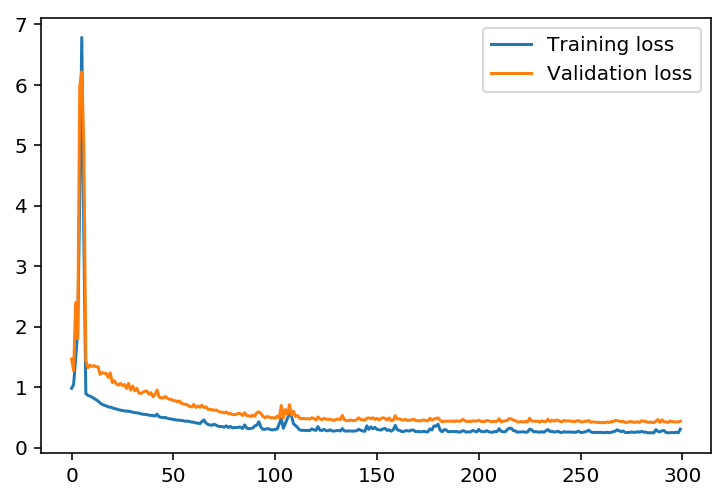

In [14]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

/Users/bnekkalapudi/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


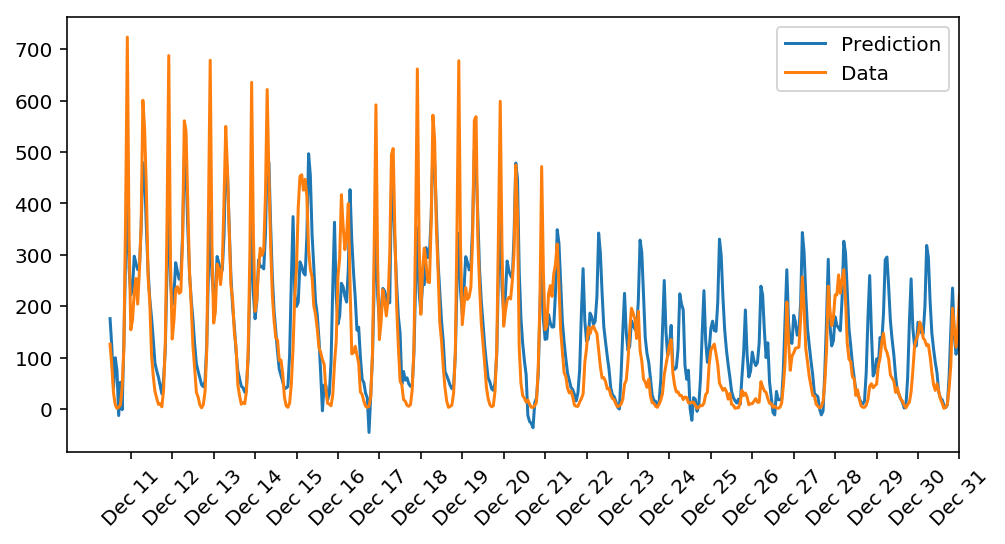

In [15]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below